# Convolutional Neural Networks

## Project: An Algorithm for Image Classification ( Dog Identification App) 

### Why We're Here 

In this notebook, you can find an image classification algorithm that could be used as part of a mobile or web app. The code will accept any user-supplied image as input, if a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of this project. 


![Sample Dog Output](images/sample_dog_output.png)     ![Sample Human Output](images/Sample_human_output.png)  

This project has pieced together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed. This algorithm can certainly be extended to detect your desired objects in an image. This CNN image classification project would be a good starting point to help understand how CNN can learn features from an image, and making good prediction of an unseen image. By changing the datasets, the CNN algorithm can be used for image recognition and OCR, object detection for self-driving cars, face recognition on social media, image analysis in healtcare, and image analysis on stock volatility in Financial market.  

### The Road Ahead

The notebook has the following separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/data/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/data/human_images`.  

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [9]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/human_images/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1
xywh 70 67 113 113


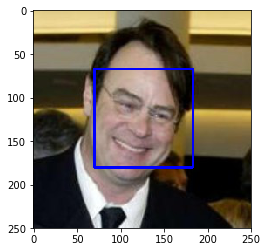

In [10]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    print("xywh",x, y, w, h)
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### A Human Face Detector Algorithm

This function returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

### (IMPLEMENTATION) Assess the Human Face Detector

We test the performance of the `face_detector` function with our images by answering below questions.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected human face and 0% of dog images with a detected human face.

__Evaluation:__ 
98% of human images with a detected face, and 17% of dog images with a detected face. The algorithm falls short of our goal, but still gives acceptable performance.

In [11]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [28]:
from tqdm import tqdm

#Extract the file paths for the first 100 images from each datasets 
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]
human = []
dog = []

#Loop 100 human images  
for image in human_files_short: 
    human_images_detected = face_detector(image)
    if human_images_detected == True: 
        human.append(human_images_detected)
#Loop 100 dog images        
for image in dog_files_short: 
    dog_images_detected = face_detector(image)
    if dog_images_detected == True:
        dog.append(dog_images_detected)
        
print("Human images detected face {}%".format(len(human)))
print("Dog images detected face {}%".format(len(dog)))

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.


Human images detected face 98%
Dog images detected face 17%


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](https://pytorch.org/vision/stable/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/update-mar-11-2021.php), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [26]:
import torch
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
print(VGG16)

# freeze gradient updates on VGG19 model
for param in VGG16.features.parameters():
    param.requires_grad = False

# Define loss using Cross Entropy 
criterion = nn.CrossEntropyLoss()

# Define classifier single gradient descent and learn rate
optimizer = optim.SGD(VGG16.classifier.parameters(), lr = 0.001)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'/data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

You may take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](https://pytorch.org/vision/stable/models.html).

In [27]:
from PIL import Image
import torchvision.transforms as transforms
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    
    image = Image.open(img_path).convert("RGB")
    
    
    # Crop and Normalize the images for pre-trained model input images
    image_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.485, 0.456, 0.406),
                                                             (0.229, 0.224, 0.225))])
    
    image = image_transform(image).unsqueeze(0)
    
    # Move images to GPU if CUDA is available
    if use_cuda:
        image = image.cuda()
    
    output = VGG16(image)
    
    # We are only interested in the predicted class, named pred
    dd, pred = torch.max(output, 1)
    
    
    return pred
    
    

### (IMPLEMENTATION) A Dog Detector Algorithm

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

The `dog_detector` function below returns `True` if a dog is detected in an image (and `False` if not).

In [28]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):

    output = VGG16_predict(img_path)
    if output>=151 and output<= 268: 
        return True
    else: 
        return False 
 

### (IMPLEMENTATION) Assess the Dog Detector

Test the performance of the `dog_detector` function by answering below questions.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Evaluation:__ 
The percentage of the images in human_files_short have a detected dog is 0%, and percentage of the images in dog_files_short have a detected dog is 99%. This is an excellent result using `dog_detector` function to detect dog.

In [32]:

dog_classify_dog = []
human_classify_dog = []

#d = dog_detector(dog_files_short[40])

for image in human_files_short:    
    d = dog_detector(image)
    if d == True:
        human_classify_dog.append(d)
    
for image in dog_files_short:
    h = dog_detector(image)
    if h == True:
        dog_classify_dog.append(h)
    
print("Dog Percentage in dog files: {}%".format(100*len(dog_classify_dog)/len(dog_files_short)))
print("Dog Percentage in human files: {}%".format(100*len(human_classify_dog)/len(human_files_short)))




Dog Percentage in dog files: 99.0%
Dog Percentage in human files: 0.0%


---
<a id='step3'></a>
## Step 3:  CNN to Classify Dog Breeds (from Scratch)

Now that you have functions for detecting humans and dogs in images, next step is to classify dog breeds from images using CNN. Below is a CNN algorithm _from scratch_ (without the use of transfer learning _yet_!). In Step 4 of this notebook, you will see the use of transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  


### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Below code cell is the three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `/data/dog_images/train`, `/data/dog_images/valid`, and `/data/dog_images/test`, respectively).  You may find [this documentation on custom datasets](https://pytorch.org/vision/stable/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](https://pytorch.org/vision/stable/transforms.html)!

In [11]:
import os
from torchvision import datasets
import torchvision.transforms as transforms
import torch
import numpy as np


data_dir = '/data/dog_images/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')
val_dir = os.path.join(data_dir, 'valid/')

# Augment train data with horizontal flip, and rotation 
image_transform_train = transforms.Compose([transforms.RandomResizedCrop(224),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.RandomRotation(30),
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.485, 0.456, 0.406),
                                                               (0.229, 0.224, 0.225))])




image_transform_valid_test = transforms.Compose([transforms.RandomResizedCrop(224),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize((0.485, 0.456, 0.406),
                                                                     (0.229, 0.224, 0.225))])
    
   

train_data = datasets.ImageFolder(train_dir, transform=image_transform_train)
valid_data = datasets.ImageFolder(val_dir, transform=image_transform_valid_test)
test_data = datasets.ImageFolder(test_dir, transform=image_transform_valid_test)


print("train", len(train_data))
print("valid", len(valid_data))
print("test", len(test_data))

batch_size = 40
num_workers = 0 
loaders_scratch={}

# Specify batch size in data loaders for training, validation, and test sets
loaders_scratch["train"] = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
loaders_scratch["valid"] = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
loaders_scratch["test"] = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

print("checking train loader", len(loaders_scratch["train"]))


train 6680
valid 835
test 836
checking train loader 167


**Evaluation**: In this data preprocessing procedure, all images are resized by cropping each image into 224 dimension square and normalised accordingly, this is because VGG16 pretrained-model expects 224 dimension and the normalization criteria. I have decided to augment my train datasets using horizontal flip, and random rotation by 30 degree, which will greatly increase the variation in training the data, resulting in better accuracy in predicting dog breeds.  

### (IMPLEMENTATION) Model Architecture

A CNN to classify dog breed. 

In [15]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3,16,3, padding=1)
        self.conv2 = nn.Conv2d(16,32,3, padding=1)
        self.conv3 = nn.Conv2d(32,64,3, padding=1)
        self.conv4 = nn.Conv2d(64,128,3, padding=1)
        
        ## Define 2X2 maxpool layer
        self.maxpool = nn.MaxPool2d(2,2)
        
        ## Define FUll connected layers
        self.fc1 = nn.Linear(128*14*14,1000)
        self.fc2 = nn.Linear(1000, 133)
        
        ## Define dropout as 20%
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        ## Define forward behavior
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = self.maxpool(F.relu(self.conv3(x)))
        x = self.maxpool(F.relu(self.conv4(x)))
        
        x = x.view(-1,128*14*14)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Evaluation:__ In this CNN architecture, there are 4 convolutional layers to detect features of input images. We mentioned previously that identifying dog breeds is a challenging task as we need to identify shapes, colors, and even facial characteristics of each dog breeds for an accurate prediction. Suppose we could go more than 4 convolutional layers but this would result in computational expensive. Each Convolutional layer is activated with Relu function, and reduce the dimension by a factor of 2 by passing through the 2X2 Maxpool layer. After that we use a view function to make sure the dimension matches to the inputs of the first fully connected layer, which is then activated with Relu function. Subsequently, we initiate the 20% dropout at the inputs of each fully connected layers to avoid data overfitting. Finally, the 2nd fully connected layer is activated by logsoftmax function provided by CrossEntropyLoss, to output 133 classes of dog breeds.     

### (IMPLEMENTATION) Specify Loss Function and Optimizer

The next code cell will specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [18]:
import torch.optim as optim

## Define cross entropy loss function
criterion_scratch = nn.CrossEntropyLoss()

## Define single gradient descent optimizer and the learn rate 
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr =0.03)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [7]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss, set infinity as initial value
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        
        # model in training mode
        model.train()
        
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move data to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            # set initial gradient as zero
            optimizer.zero_grad()
            
            # generate output from the model
            output = model(data)
           
            # calculate loss function
            loss = criterion(output, target)
            
            # gradients are stored by the tensors themselves
            loss.backward()
            
            # update values with gradients 
            optimizer.step()
           
            # find the loss and update the model parameters accordingly
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))#*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        
        # model switch to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            
            loss = criterion(output, target)
            
            valid_loss = (train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss)))#*data.size(0)
            
            ## update the average validation loss
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print("validation loss decreased ({:.6f}----->{:.6f}) (model saved)".format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model


In [19]:

# train the model
model_scratch = train(100, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.817845 	Validation Loss: 4.811130
validation loss decreased (inf----->4.811130) (model saved)
Epoch: 2 	Training Loss: 4.698969 	Validation Loss: 4.690626
validation loss decreased (4.811130----->4.690626) (model saved)
Epoch: 3 	Training Loss: 4.608101 	Validation Loss: 4.603649
validation loss decreased (4.690626----->4.603649) (model saved)
Epoch: 4 	Training Loss: 4.568275 	Validation Loss: 4.562961
validation loss decreased (4.603649----->4.562961) (model saved)
Epoch: 5 	Training Loss: 4.534467 	Validation Loss: 4.540850
validation loss decreased (4.562961----->4.540850) (model saved)
Epoch: 6 	Training Loss: 4.507119 	Validation Loss: 4.505417
validation loss decreased (4.540850----->4.505417) (model saved)
Epoch: 7 	Training Loss: 4.483566 	Validation Loss: 4.478548
validation loss decreased (4.505417----->4.478548) (model saved)
Epoch: 8 	Training Loss: 4.457900 	Validation Loss: 4.464404
validation loss decreased (4.478548----->4.464404) (model save

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  The code cell below will calculate and print the test loss, and accuracy.

In [17]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the loss
        loss = criterion(output, target)
        
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [20]:
# call test function 
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.097854


Test Accuracy: 18% (153/836)


__Evaluation__: The test accuracy is 18% as shown as above. Although this test accuracy is far from our ideal 70%-100% test accuracy, it has certainly performed way better than 1% test accuracy by random guessing (1 out of 133 classes) the dog breed. The reason for the low accuracy is that the CNN has not trained sufficient enough with more layers and images to be able to identify more complicated features in an image, in our case the dog breed features.       

---
<a id='step4'></a>
## Step 4: CNN to Classify Dog Breeds (using Transfer Learning)

Now we use transfer learning to create a CNN that can identify dog breed from images.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

The code cell below is three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `data/dog_images/train`, `data/dog_images/valid`, and `data/dog_images/test`, respectively). 


In [18]:
import os
from torchvision import datasets
import torchvision.transforms as transforms
import torch
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


data_dir = '/data/dog_images/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')
val_dir = os.path.join(data_dir, 'valid/')


image_transform_train = transforms.Compose([transforms.RandomResizedCrop(224),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.RandomRotation(30),
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.485, 0.456, 0.406),
                                                               (0.229, 0.224, 0.225))])




image_transform_valid_test = transforms.Compose([transforms.RandomResizedCrop(224),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize((0.485, 0.456, 0.406),
                                                                     (0.229, 0.224, 0.225))])
    
   
 
train_data = datasets.ImageFolder(train_dir, transform=image_transform_train)
valid_data = datasets.ImageFolder(val_dir, transform=image_transform_valid_test)
test_data = datasets.ImageFolder(test_dir, transform=image_transform_valid_test)


print("train", len(train_data))
print("valid", len(valid_data))
print("test", len(test_data))

batch_size = 40
num_workers = 0 
loaders_transfer={}

loaders_transfer["train"] = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
loaders_transfer["valid"] = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
loaders_transfer["test"] = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

print("checking train loader", len(loaders_transfer["train"]))




train 6680
valid 835
test 836
checking train loader 167


### (IMPLEMENTATION) Model Architecture

Below is a CNN using transfer learning to classify dog breed.  The code cell below will save the initialized model as the variable `model_transfer`.

In [21]:
import torch
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
print(VGG16)

for param in VGG16.features.parameters():
    param.requires_grad = False

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [22]:
VGG16.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [23]:
import torchvision.models as models
import torch.nn as nn

# specify the last fully connected layer to output 133 classes of dog breeds    
c6input = VGG16.classifier[6].in_features

fc1 = nn.Linear(c6input, 133)
VGG16.classifier[6] = fc1

model_transfer = VGG16

if use_cuda:
    model_transfer = model_transfer.cuda()
    
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

__Evaluation:__ 
In the architecture of transfer learning with VGG16, the model features gradient update is set to false because we only want the convolutional layers to act as the feature detectors to the image. We then train the model classifier and update the gradient of the fully connected layers for dog breeds classification. The last fully connected layer is changed with output features set to 133 classes for all our dog breeds classes.  

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [13]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr = 0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate the model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [15]:
# train the model for 50 epochs
model_transfer = train(50, loaders_transfer, model_transfer, optimizer_transfer, 
                       criterion_transfer, use_cuda, 'model_transfer.pt')


Epoch: 1 	Training Loss: 1.427249 	Validation Loss: 1.402222
validation loss decreased (inf----->1.402222) (model saved)
Epoch: 2 	Training Loss: 1.338445 	Validation Loss: 1.320552
validation loss decreased (1.402222----->1.320552) (model saved)
Epoch: 3 	Training Loss: 1.312762 	Validation Loss: 1.285309
validation loss decreased (1.320552----->1.285309) (model saved)
Epoch: 4 	Training Loss: 1.260045 	Validation Loss: 1.241361
validation loss decreased (1.285309----->1.241361) (model saved)
Epoch: 5 	Training Loss: 1.210633 	Validation Loss: 1.180479
validation loss decreased (1.241361----->1.180479) (model saved)
Epoch: 6 	Training Loss: 1.181971 	Validation Loss: 1.163074
validation loss decreased (1.180479----->1.163074) (model saved)
Epoch: 7 	Training Loss: 1.162180 	Validation Loss: 1.135914
validation loss decreased (1.163074----->1.135914) (model saved)
Epoch: 8 	Training Loss: 1.177467 	Validation Loss: 1.160132
Epoch: 9 	Training Loss: 1.134279 	Validation Loss: 1.141050
E

In [24]:
# load the model that got the best validation accuracy 
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'

model_transfer.load_state_dict(torch.load('model_transfer.pt', map_location=map_location))


### (IMPLEMENTATION) Test the Model

Try out the model on the test dataset of dog images. Calculate and print the test loss and accuracy.

In [18]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.762240


Test Accuracy: 78% (654/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Below function takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [20]:
import numpy as np
from glob import glob

# load filenames for human and dog images
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in dog dataset
print('There are %d total dog images.' % len(dog_files))

There are 8351 total dog images.


In [3]:
### Return the dog breed that is predicted by the model.

import matplotlib.pyplot as plt
from PIL import Image

def predict_breed_transfer(img_path, model_transfer):
    
    image = Image.open(img_path).convert("RGB")
    
    image_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.485, 0.456, 0.406),
                                                             (0.229, 0.224, 0.225))])
    
    
    image = image_transform(image).unsqueeze(0)
    
    if use_cuda:
        image = image.cuda()
    
    # Use a pretrained model to predict the output class 
    output = model_transfer(image)
    dd, pred = torch.max(output, 1)
    
    # Below image transform is to retain most properties of the image when plotting the image
    image = Image.open(img_path).convert("RGB")
    image_transform = transforms.Compose([transforms.ToTensor(),
                                            transforms.Normalize((0.485, 0.456, 0.406),
                                                                (0.229, 0.224, 0.225))])
    original_image = image_transform(image).unsqueeze(0)
    
    return pred, original_image

Text(0.5,1,'Mastiff')

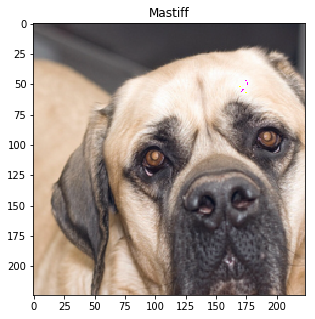

In [61]:


# specify dog_files[0] path as an input image
img_path = dog_files[5]

# predict dog breed class 
output, image = predict_breed_transfer(img_path, model_transfer)

# get index for all dog breeds 
class_names = [item[4:].replace("_", " ") for item in train_data.classes]

# get dog breed name for the predicted class index
dogname = class_names[output]



############################################## Plot dog image
# convert tensors to numpy for input image plotting  
image = image.numpy()
image = image.squeeze(0)

# unnormalize the image
image = image* (1/(2*2.25)) + 0.5 

# show input image with the dog breed name as title
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
plt.imshow(np.transpose(image, (1, 2, 0)))
ax.set_title(dogname)



---
<a id='step5'></a>
## Step 5: Dog app Algorithm

This algorithm accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

### (IMPLEMENTATION) Write your Algorithm

In [1]:
def print_image(output, image, message):
    
    if output != 0:
        class_names = [item[4:].replace("_", " ") for item in train_data.classes]
        dogname = class_names[output]
    else:
        dogname = "(Not able to identify)"
        
    # convert tensors to numpy for input image plotting 
    image = image.numpy()
    image = image.squeeze(0)

    # unnormalize the image
    image = image* (1/(2*2.25)) + 0.5 

    # show input image with the dog breed name as title
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    plt.imshow(np.transpose(image, (1, 2, 0)))
    ax.set_title("{} {}".format(message, dogname))

In [12]:

def run_app(img_path):
    # check for human face, return number of faces in an image 
    check_human = face_detector(img_path)
    
    # if human face detected, we proceed to predict its resembling dog breed
    if check_human > 0: 
        message = "Hello Human, you look like a "
        output, image = predict_breed_transfer(img_path, model_transfer)
        print_image(output, image, message)
    
    # no human face detected, check for dog in the image
    else:
        
        # check for dog in an image using VGG16, by looking whether output falls between 151 and 268 dog classes
        check_dog = dog_detector(img_path)
        
        # if dog is detected in an image, we proceed to predict the dog breed 
        # using the trained classifier transfer learning VGG16 model we saved previously
        if check_dog == True: 
            message = "Dog detected, this is a "
            output, image = predict_breed_transfer(img_path, model_transfer)
            print_image(output, image, message)
        
        # if neither dog nor human in an image. print error message
        elif check_dog == False:
            message = "ERROR!!!! Please upload a human/dog image for dog breed prediction"
            image = Image.open(img_path)#.convert("RGB")
        
            image_transform = transforms.Compose([transforms.ToTensor(),
                                                transforms.Normalize((0.485, 0.456, 0.406),
                                                                     (0.229, 0.224, 0.225))])
        
    
            image = image_transform(image).unsqueeze(0)
            print_image(0,image,message)

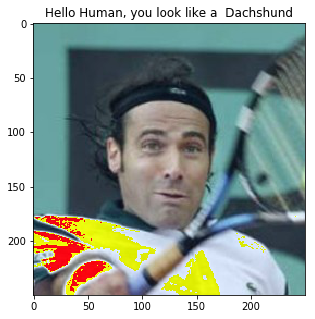

In [87]:

#dog_files or human_files testing 
run_app(human_files[1])
#run_app(dog_files[0])

---
<a id='step6'></a>
## Step 6: Test the dog app algorithm

### (IMPLEMENTATION) Test Algorithm on Complicated Images!

Test the dog app algorithm with more complicated images, instead of using single dog/human in an image. We would like to see whether it predicts your dog's breed accurately? Does the algorithm mistakenly predict a cat as a dog? Does it mistakenly detect a cartoon character as human? 

__Points for improvement__: 
1. When detecting a human in an image, the face detector using opencv is not accurate enough to differentiate a real human or a fake human that made of plastic as shown in picture 12 below. To improve this, we can add a classifier that is trained to classify fake plastic human and real human. Also note that in picture 3 below, face detector has wrongly classified a dog as human, this can also be improved by adding classifier to differentiate animals from humans. 

2. If both human and dog are present in an image as shown in picture 14 below, it will only detect the human in the image. To improve this, we can combine 2 or more models together for a collective output to an image, for example one model will detect the human features and the race of a human, while another model will detect dog features and dog breeds, as a result, an image that passes through this combined model will have both human and dog detected.

3. When different dog breeds are present in one image, the model will fail. We need to build convolutional layers to detect number of dogs in one image, and then classify the dog breeds for all the dogs in an image.     


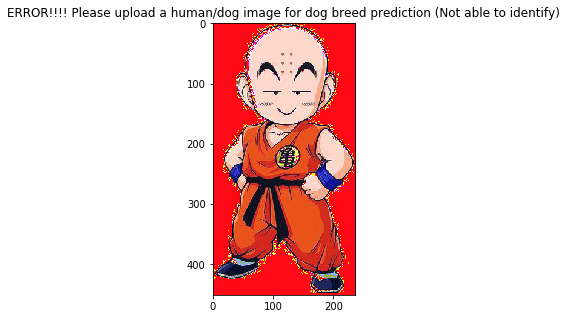

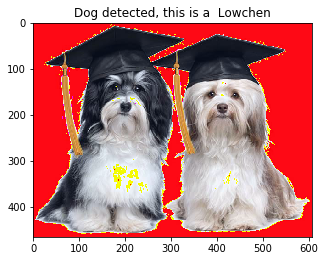

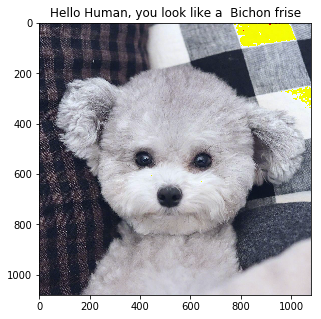

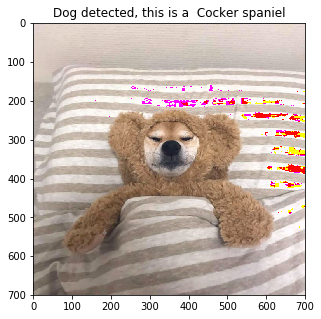

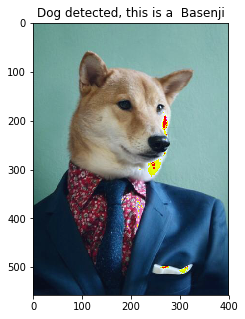

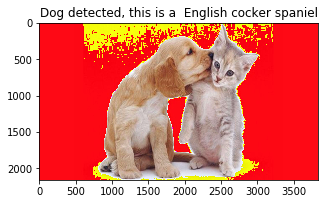

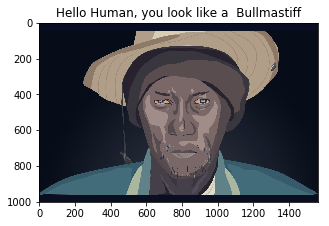

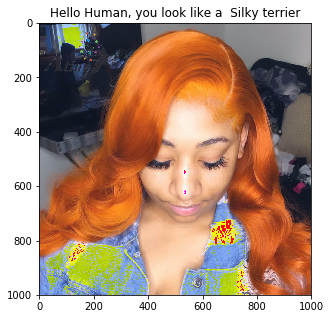

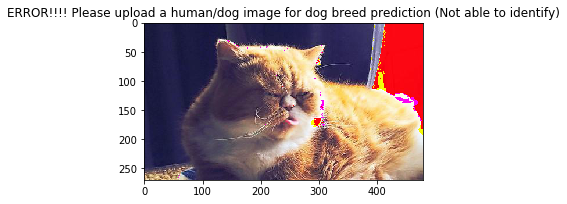

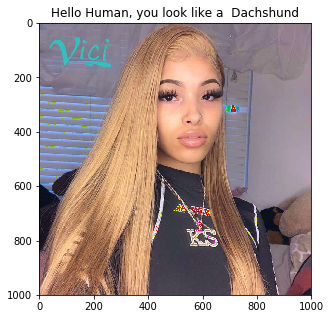

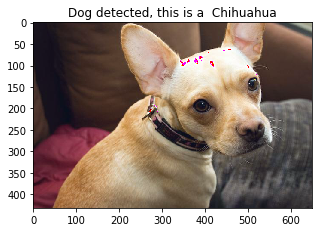

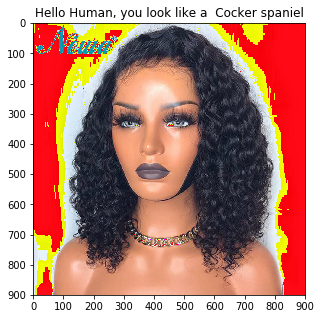

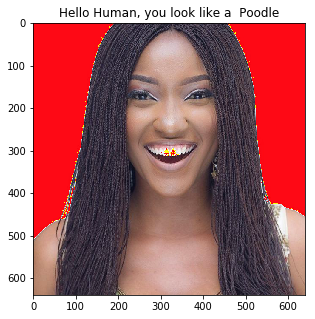

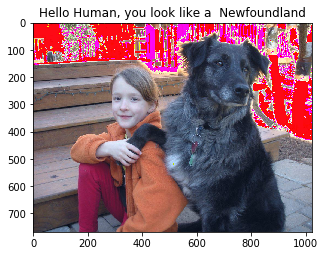

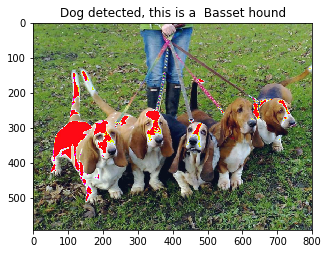

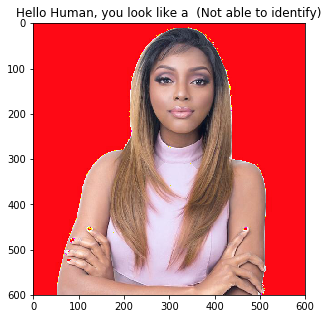

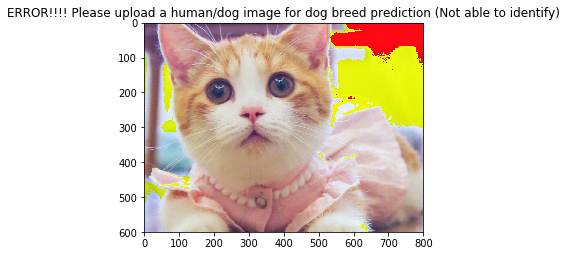

In [29]:
import numpy as np

# load filenames for human and dog images
all_images = np.array(glob("my_images/*"))

for file in np.hstack((all_images)):
    run_app(file)